In [ ]:
import numpy as np
import importlib
import syntheticChrissAlmgren as sca
import ddpg_agent
from ddpg_agent import Agent
from price_models import GeometricBrownianMotion, ArithmeticBrownianMotion
from collections import deque
importlib.reload(sca)
importlib.reload(ddpg_agent)

mu    = 0.0
sigma = sca.DAILY_VOLAT

<module 'ddpg_agent' from 'c:\\Users\\itspa\\Downloads\\Personal Projects\\newtone-bootcamp-final-project\\financial\\finance\\ddpg_agent.py'>

In [ ]:
gbm = GeometricBrownianMotion(mu=mu, sigma=sigma)

abm = ArithmeticBrownianMotion(mu=mu, sigma=sigma)

env = sca.MarketEnvironment(price_model=gbm)

agent = Agent(
    state_size=env.observation_space_dimension(),
    action_size=env.action_space_dimension(),
    random_seed=0
)

# ------------- Training hyperparameters ------------------------------ #
lqt      = 60      # liquidation time
n_trades = 60      # number of steps
tr       = 1e-6    # risk‐aversion λ
episodes = 10000

shortfall_hist  = np.array([])
shortfall_deque = deque(maxlen=100)

for episode in range(episodes):
    # reset with the new signature
    state = env.reset(
        seed=episode,
        liquid_time=lqt,
        num_trades=n_trades,
        lamb=tr
    )
    env.start_transactions()

    for t in range(n_trades + 1):
        action, _ = agent.act(state, add_noise=True)[:2]  # if your act() returns more than just action
        next_state, reward, done, info = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state

        if done:
            shortfall = info.implementation_shortfall
            shortfall_hist = np.append(shortfall_hist, shortfall)
            shortfall_deque.append(shortfall)
            break

    if (episode + 1) % 100 == 0:
        avg = np.mean(shortfall_deque)
        print(f"Episode {episode+1}/{episodes}  —  Avg Shortfall: ${avg:,.2f}")

print(f"\nDone!  Overall Avg Shortfall: ${np.mean(shortfall_hist):,.2f}")


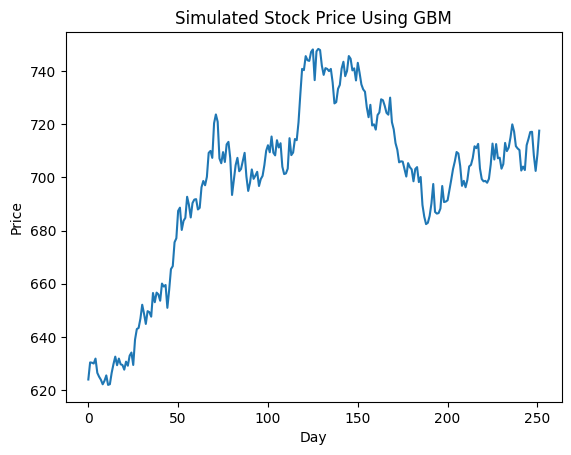

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf


ticker = yf.Ticker("SPY")
latest = ticker.history(period="1d")

# Get just the latest close price
latest_close = latest['Close'].iloc[-1]


S0 = latest_close        # starting stock price
mu = 0.0       # expected annual return
sigma = 0.1123   # annual volatility
T = 1           # time in years
N = 252         # number of steps
dt = T / N      # time step size

Z = np.random.normal(0, 1, N)

S = np.zeros(N)
S[0] = S0
for t in range(1, N):
    S[t] = S[t-1] * np.exp((mu - 0.5 * sigma**2)*dt + sigma*np.sqrt(dt)*Z[t])

plt.plot(S)
plt.title("Simulated Stock Price Using GBM")
plt.xlabel("Day")
plt.ylabel("Price")
plt.show()